In [12]:
# imports
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations


In [13]:
# constants to be used for model
DV = 'SalePrice'                # dependent variable
CORR_THRESHOLD = 0.25           # correlation threshold
P_VAL_THRESHOLD = 0.1          # p-value threshold
MULTI_COLLIN_THRESHOLD = 0.65    # multi collinearity threshold


In [14]:
file_path = './train.csv'

# load data from file path, NOTE: data must be in .csv format!
df = pd.read_csv(file_path)
df.head(5)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [15]:
# -- DATA CLEANUP -- #

# get all columns that consist of numerical data
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']

# remove all non-numeric columns
df = df.select_dtypes(include=numerics)

# remove any columns containing NAs
df.dropna(axis=1, inplace=True)

# columns to exclude
# cols_to_exclude = ['Id', 'LowQualFinSF', 'BsmtHalfBath']
cols_to_exclude = ['Id']

# remove categorical columns
df = df.loc[:, ~df.columns.isin(cols_to_exclude)]

# df.to_csv('updated_train.csv')

print(f'{df.shape = }')
# df.to_csv('clean_data.csv')
df.head()
print(list(df.columns))


df.shape = (1460, 34)
['MSSubClass', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold', 'SalePrice']


In [16]:
# sanity check for NAs
for col in df.isnull().any():
    if col:
        print('NA found!')
        break
print('If "NA found!" not printed, then the dataset is good to go!')


If "NA found!" not printed, then the dataset is good to go!


In [17]:
def correlation_heatmap(data: pd.DataFrame, title: str = 'Pearson Correlation of Features', labelsize: int = 12):
    """Plots a heatmap of correlation values

    Args:
        data (pd.DataFrame): dataframe to observe correlation values of
        title (str, optional): plot title. Defaults to 'Pearson Correlation of Features'.
        labelsize (int, optional): size of labels. Defaults to 12.
    """
    # Only ax is used in following code, we do not assign value to the other variable
    _, ax = plt.subplots(figsize=(30, 30))
    data = data.drop('const', axis=1)
    colormap = sns.diverging_palette(240, 10, as_cmap=True)
    mask = np.triu(data.corr())
    np.fill_diagonal(mask, False)
    heatmap = sns.heatmap(
        data.corr().round(3),
        mask=mask,
        cmap=colormap,
        square=True,
        cbar_kws={'shrink': .9},
        ax=ax,
        annot=True,
        linewidths=0.1, vmax=1.0, linecolor='black',
        annot_kws={'fontsize': 13}
    )

    # change location of x-axis tick and labels
    # heatmap.xaxis.set_label_position('top')
    # heatmap.xaxis.tick_top()

    heatmap.collections[0].colorbar.ax.tick_params(labelsize=labelsize)

    plt.title(title, y=1.05, size=24)
    plt.tick_params(axis='both', which='major', labelsize=labelsize)

    return heatmap


In [18]:
first_half_df = len(df) // 2 - 1
second_half_df = first_half_df + 1

# create training data (1st half of df)
x_train = df.loc[:first_half_df, df.columns != DV]
y_train = df.loc[:first_half_df, DV]

# create validation data (2nd half of df)
x_val = df.loc[second_half_df:, df.columns != DV]
y_val = df.loc[second_half_df:, DV]

# verify that shapes are correct
print(f'{x_train.shape = }')
print(f'{y_train.shape = }')
print(f'{x_val.shape = }')
print(f'{y_val.shape = }')


x_train.shape = (730, 33)
y_train.shape = (730,)
x_val.shape = (730, 33)
y_val.shape = (730,)


In [19]:
# function that eliminates variables that don't meet p-value threshold
def eliminate_by_p_value(x_train, p_values):
    print('\t\t\t----- ELIMINATE BY P-VALUE -----')
    cols_to_exclude = []
    assert len(x_train.columns) == len(p_values)
    for iv, p_val in zip(x_train, p_values):
        if iv == 'const':
            continue
        if p_val > P_VAL_THRESHOLD:
            cols_to_exclude.append(iv)
            print(
                f'Remove {iv}\t-- P-Value --\tp_val = {round(p_val, 3)} > {P_VAL_THRESHOLD}')
    return cols_to_exclude


In [20]:
# function that eliminates variables that don't meet correlation criteria
def eliminate_by_correlation(x_train, y_train, excluded_list):
    print('\t\t\t----- ELIMINATE BY CORRELATION / COLLINEARITY -----')
    res = pd.concat([x_train, y_train], axis=1, join='inner')
    corr = res.corr()
    fields = list(res.columns)
    cols_to_exclude = fields.copy()

    # ignore variables that have already been excluded
    for ex in excluded_list:
        cols_to_exclude.remove(ex)

    exclude_cols = []

    sales_price_corrs = {}
    collinearity_errs = []

    for f1, f2 in combinations(fields, 2):
        # ignore the constant variable
        if f1 == 'const' or f2 == 'const':
            continue

        # eliminate IVs with correlation with DV not within threshold
        if f2 == DV:
            sales_price_corrs[f1] = corr.loc[f1, f2]
            if abs(corr.loc[f1, f2]) < CORR_THRESHOLD:
                if f1 in cols_to_exclude:
                    print(
                        f'Remove {f1}\t-- Correlation --\t{round(corr.loc[f1, f2], 3)} < {CORR_THRESHOLD}')
                    exclude_cols.append(f1)
            continue

        # high multicollinearity between variables
        if f2 != DV:
            if abs(corr.loc[f1, f2]) > MULTI_COLLIN_THRESHOLD:
                collinearity_errs.append([f1, f2, corr.loc[f1, f2]])

    # for each pair of variables with high collinearity, exclude the one with lowest correlation with DV
    for f1, f2, val in collinearity_errs:
        assert f1 in sales_price_corrs.keys() and f2 in sales_price_corrs.keys()
        if sales_price_corrs[f1] < sales_price_corrs[f2]:
            if f1 in cols_to_exclude:
                print(
                    f'Remove {f1}\t-- Collinearity --\tColl. with {f2} => {round(sales_price_corrs[f1], 3)} < {round(sales_price_corrs[f2], 3)}')
                exclude_cols.append(f1)
        elif sales_price_corrs[f1] > sales_price_corrs[f2]:
            if f2 in cols_to_exclude:
                print(
                    f'Remove {f2}\t-- Collinearity --\tColl. with {f1} => {round(sales_price_corrs[f2], 3)} < {round(sales_price_corrs[f1], 3)}')
                exclude_cols.append(f2)

    return exclude_cols


-------------------------------------ITERATION 1-------------------------------------

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.846
Model:                            OLS   Adj. R-squared:                  0.839
Method:                 Least Squares   F-statistic:                     123.4
Date:                Sun, 27 Mar 2022   Prob (F-statistic):          1.50e-259
Time:                        22:05:02   Log-Likelihood:                -8611.7
No. Observations:                 730   AIC:                         1.729e+04
Df Residuals:                     698   BIC:                         1.743e+04
Df Model:                          31                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

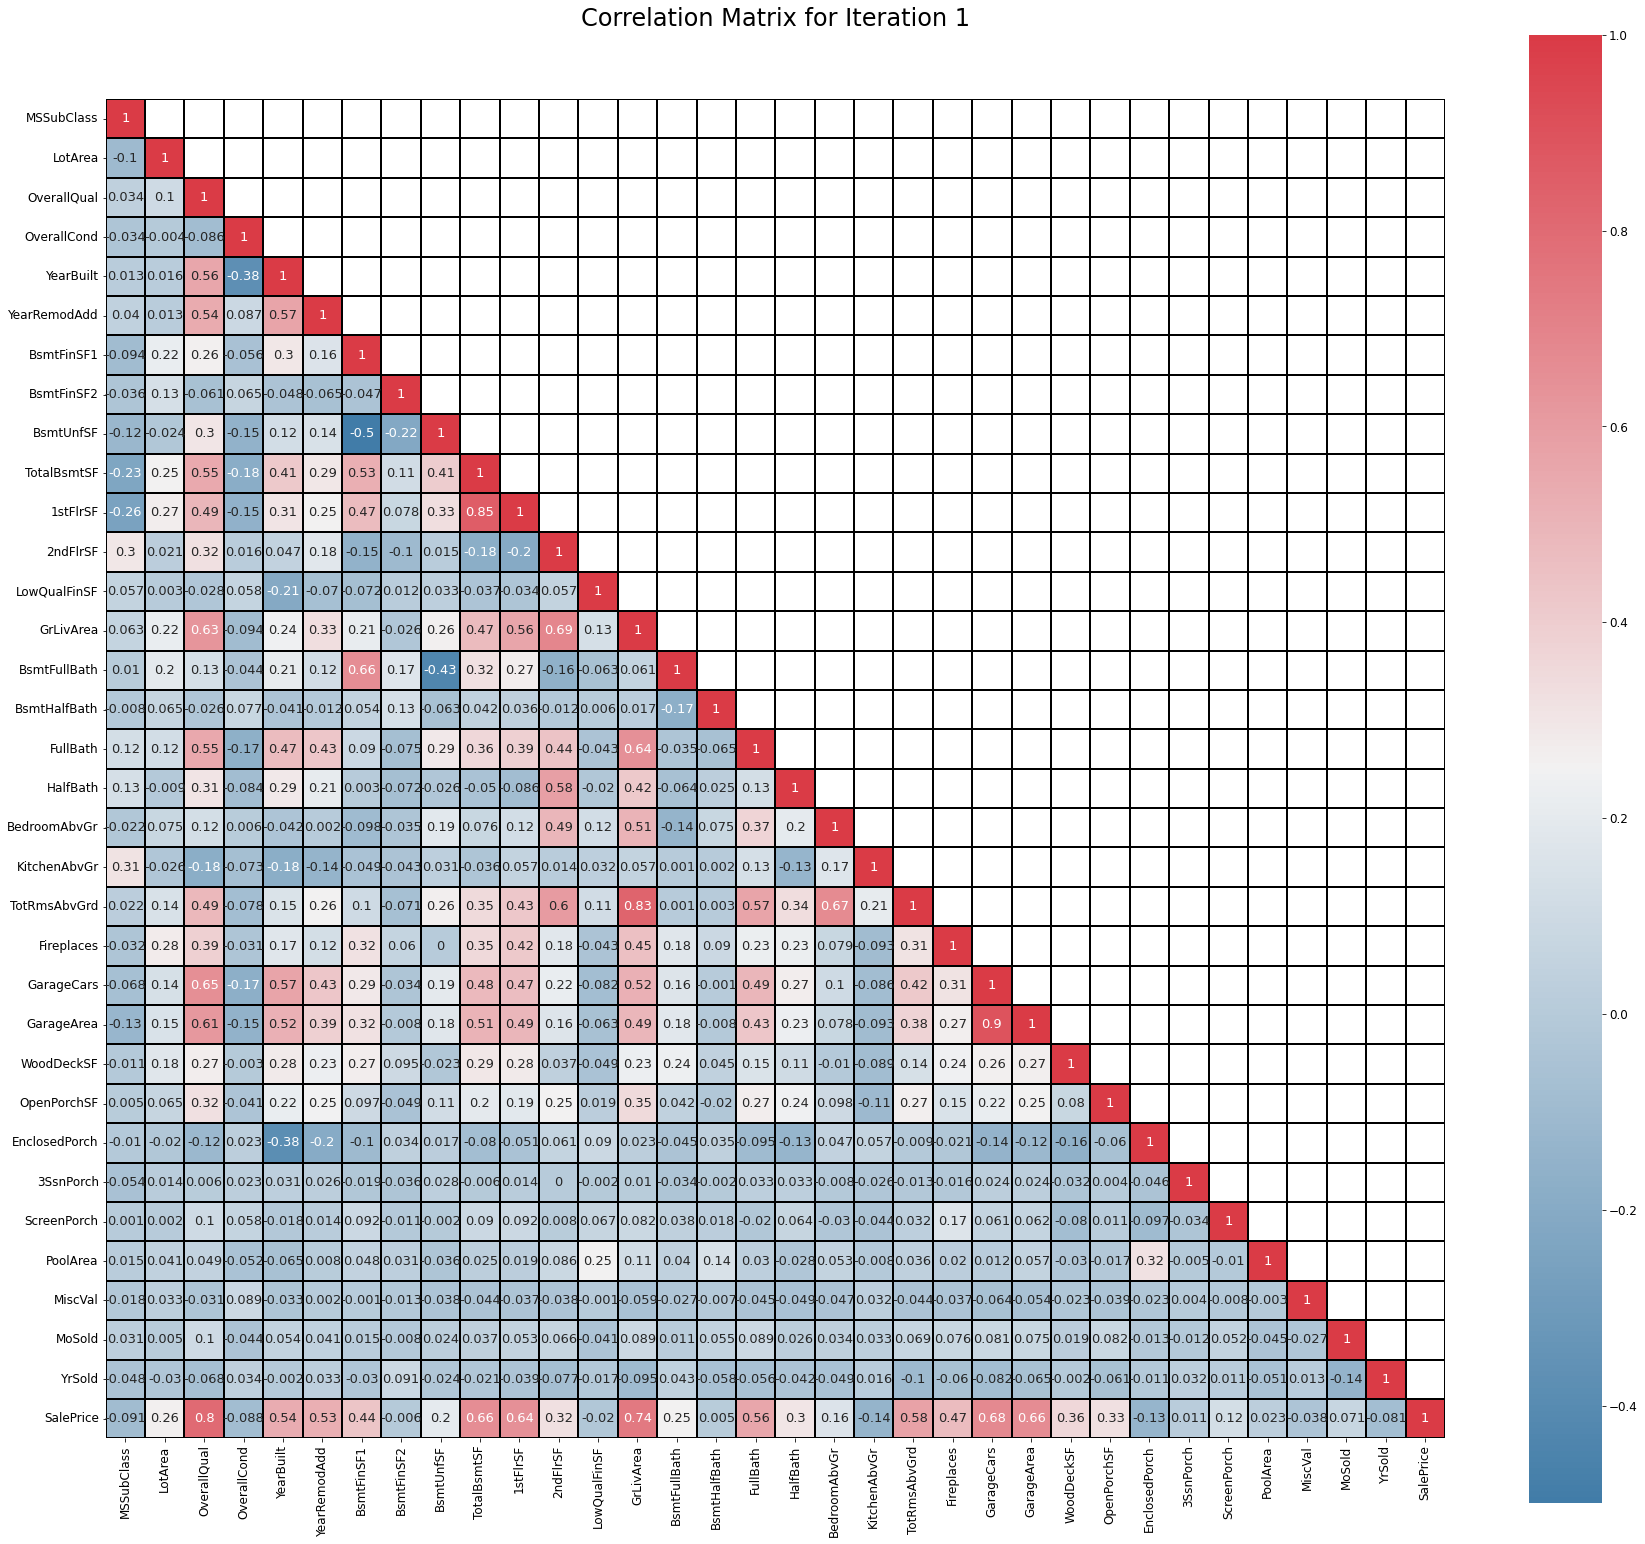

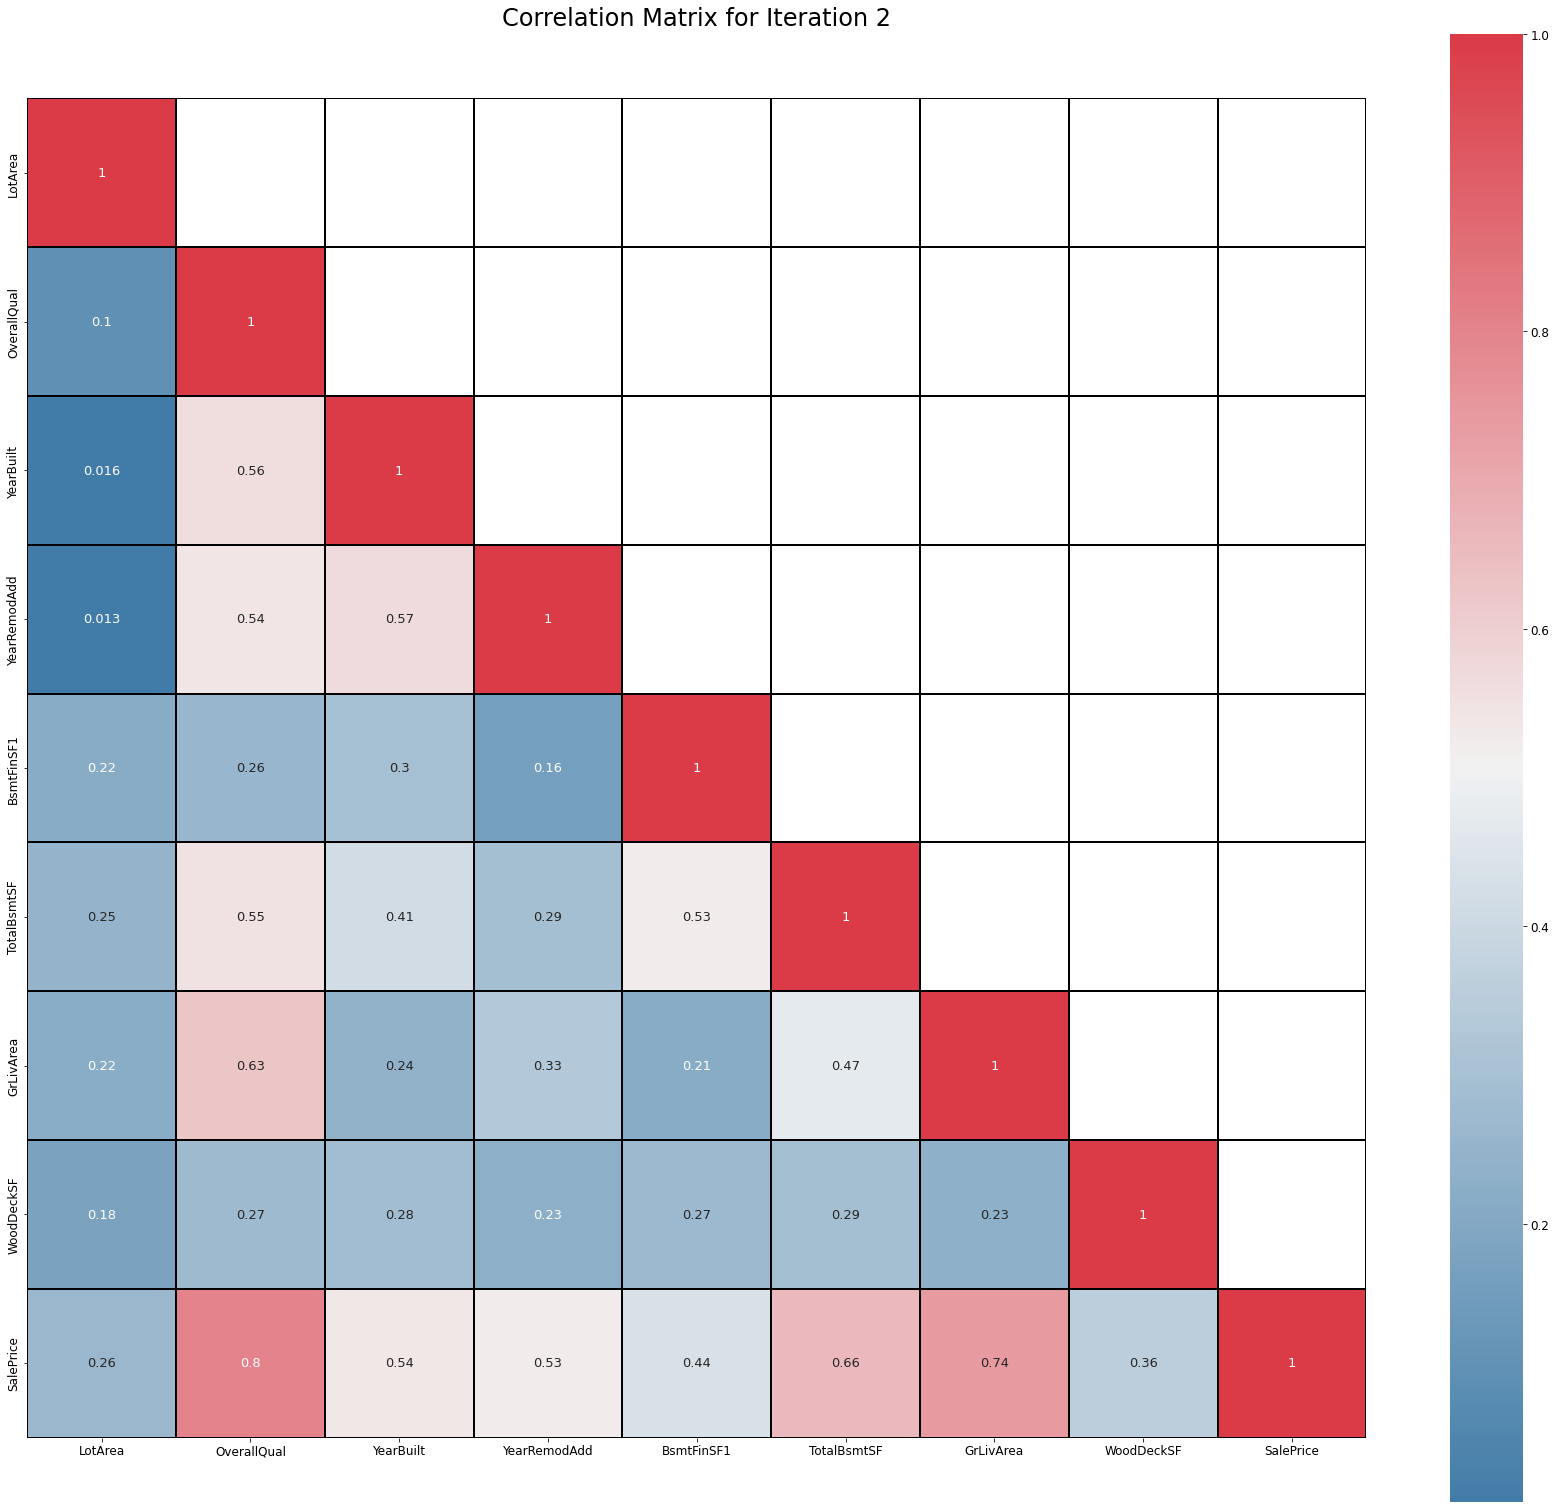

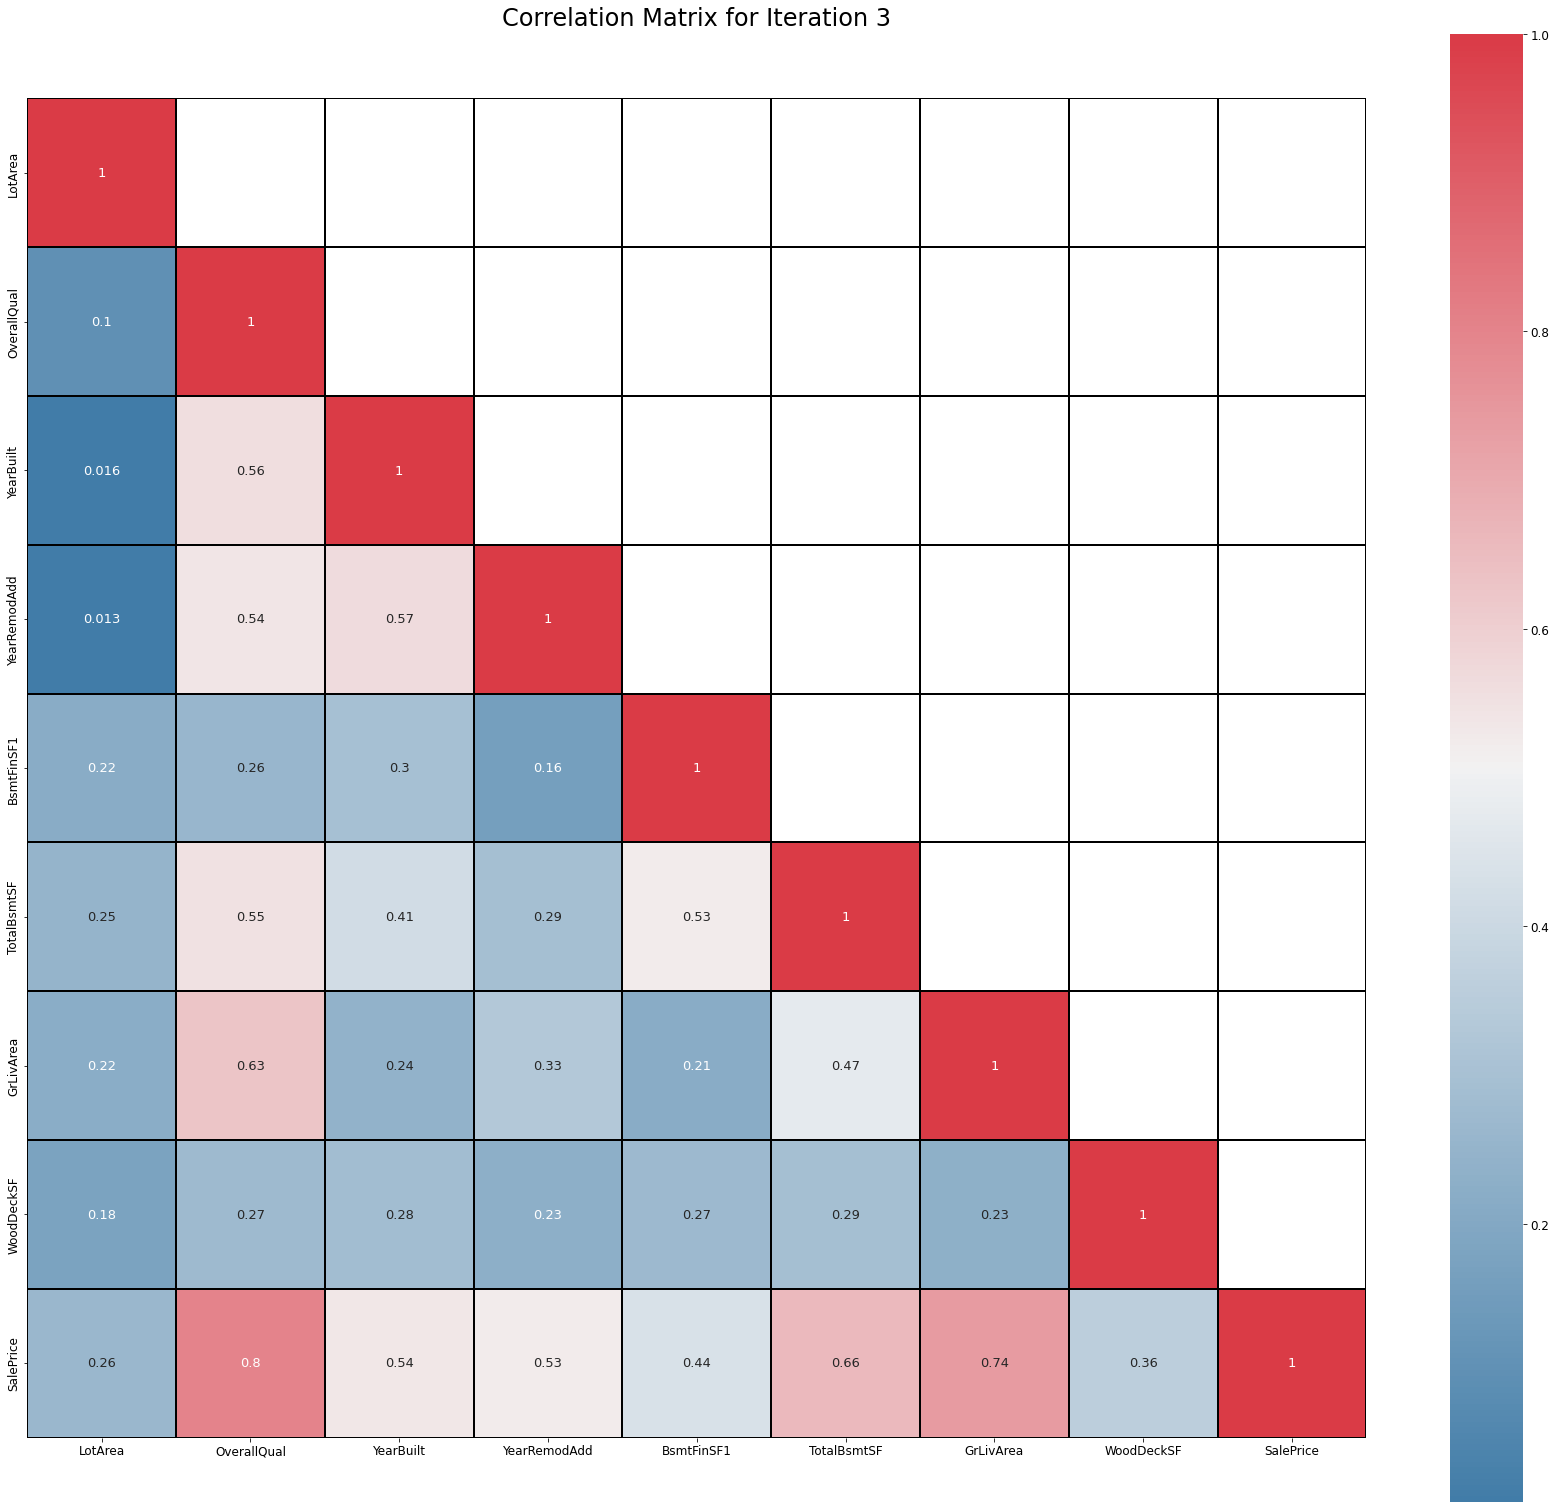

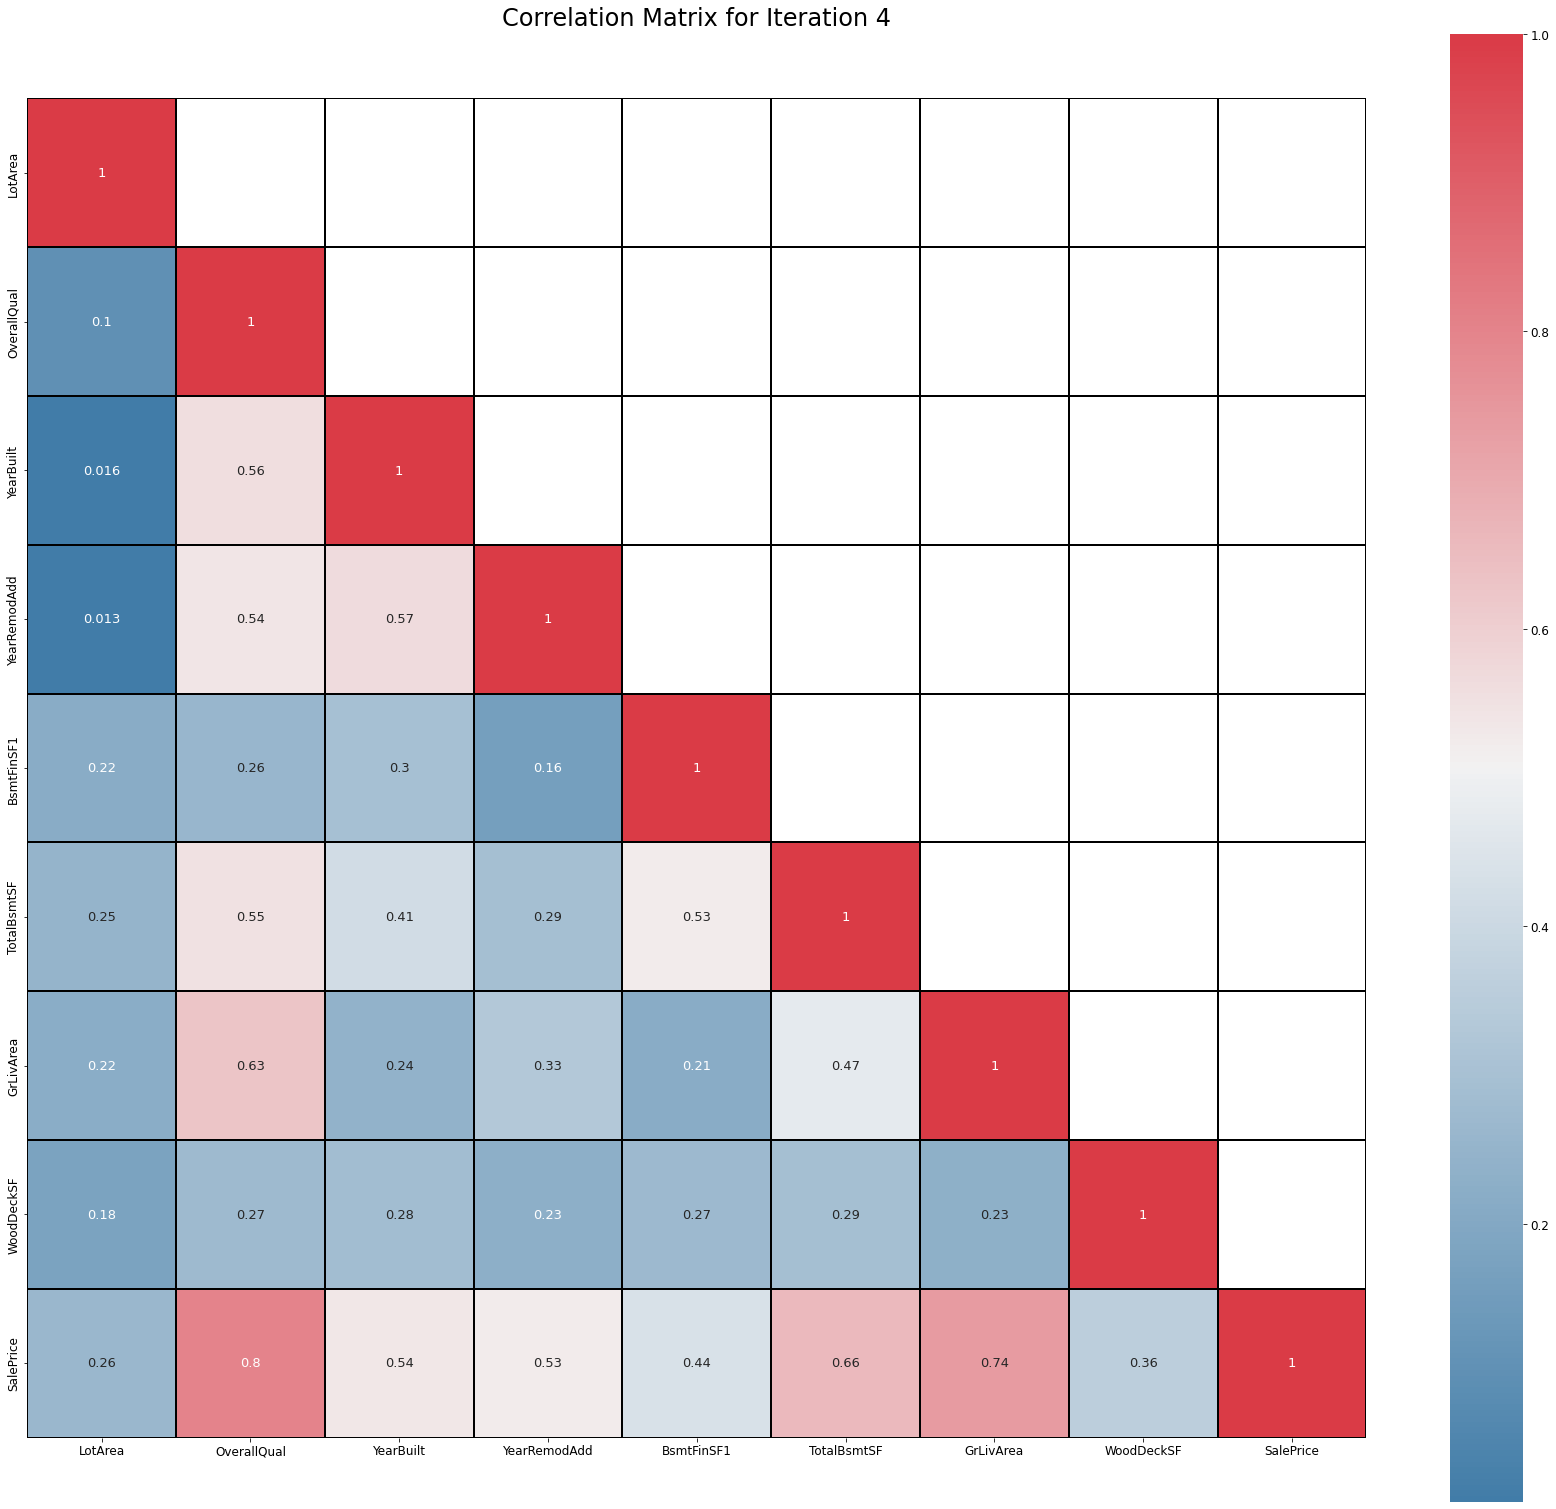

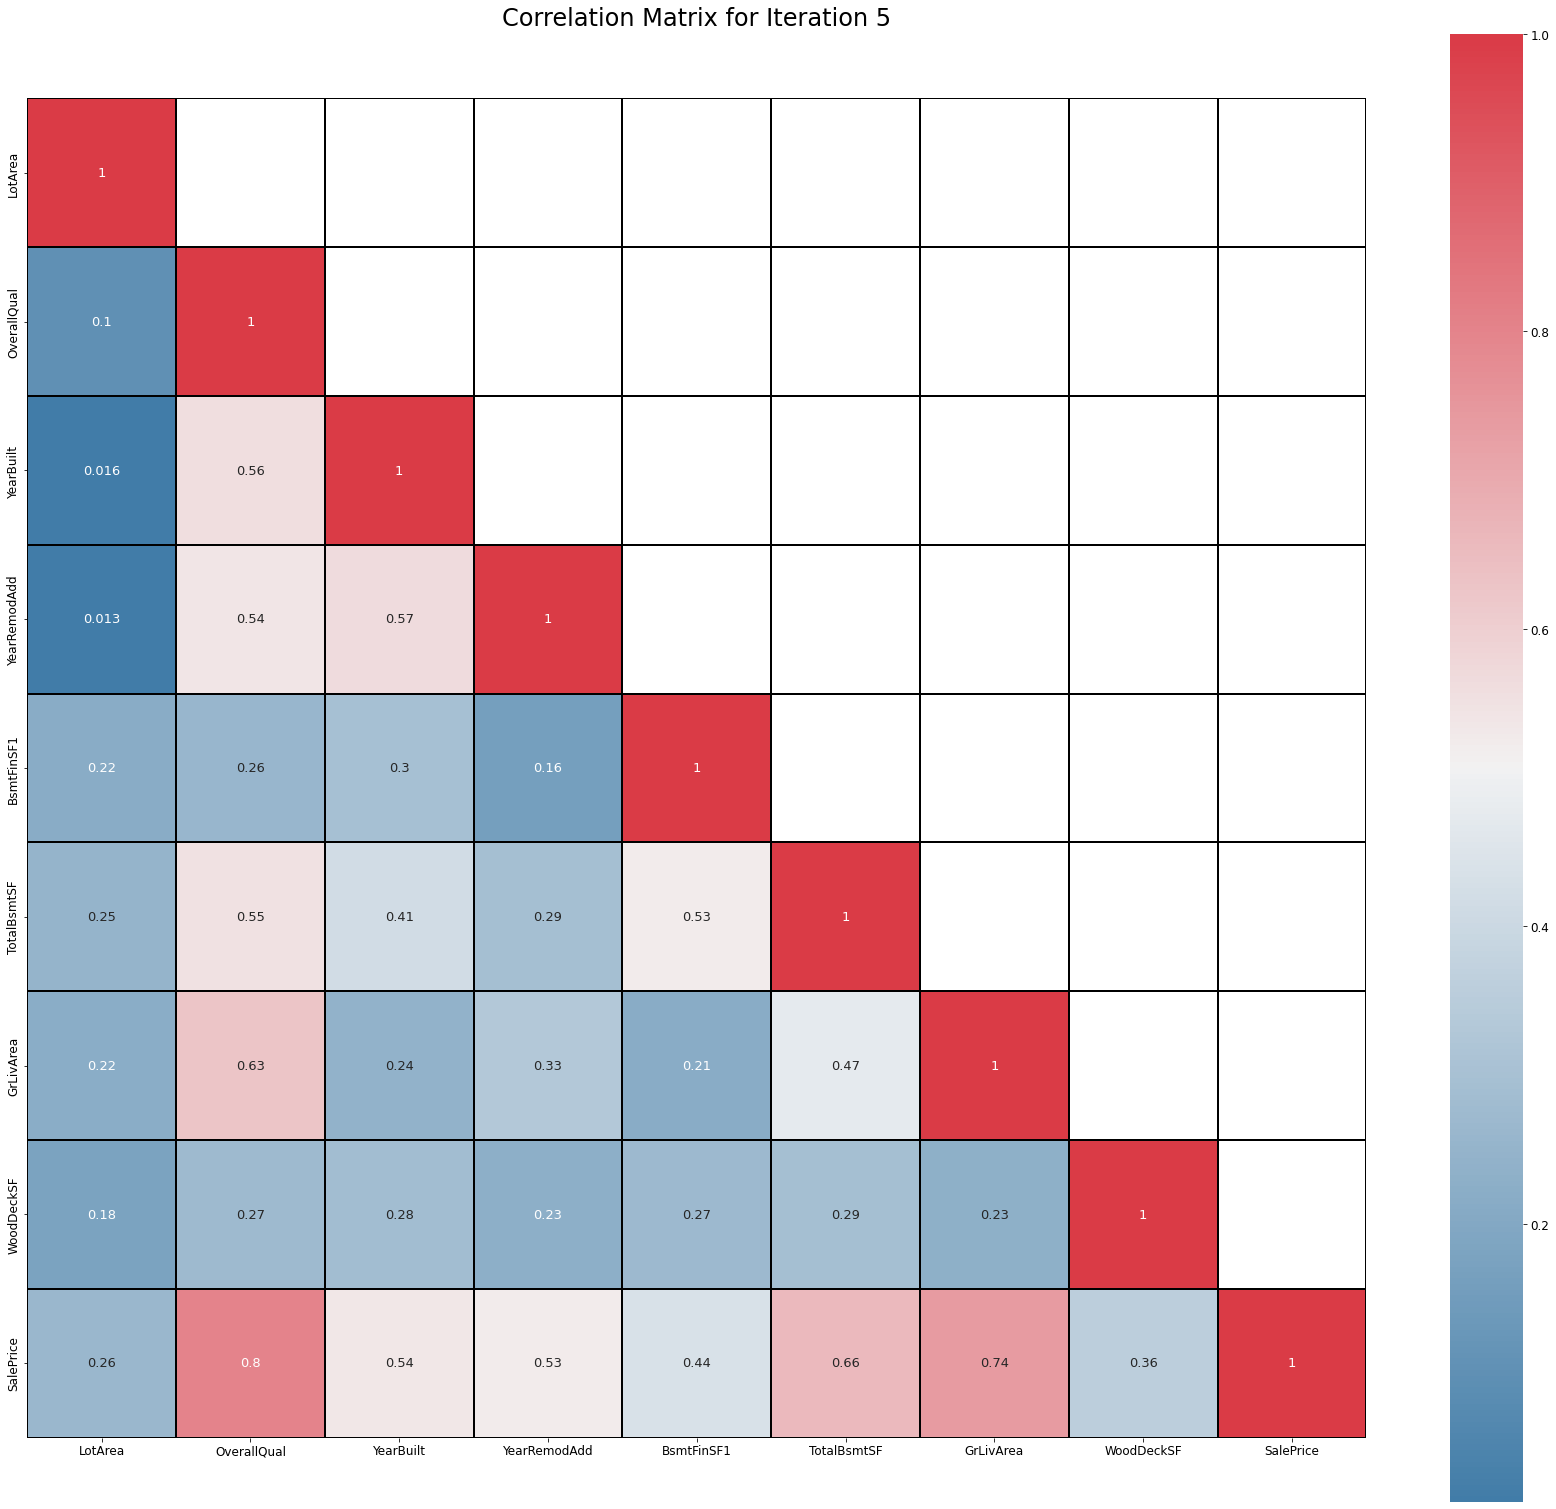

In [21]:
# results of each iteration
avg_val_errs = []
mapes = []
coefs_arr = []
r2_arr = []
coefs_names = []

NUM_ITERATIONS = 4

iteration = 1
while iteration <= NUM_ITERATIONS + 1:
    x_train = sm.add_constant(x_train)
    x_val = sm.add_constant(x_val)
    x2 = x_train.copy()
    x_val = x_val.loc[:, x_val.columns.isin(list(x_train.columns))]

    correlation_heatmap(pd.concat([x_train, y_train], axis=1, join='inner'),
                        title=f'Correlation Matrix for Iteration {iteration}')

    print(
        f'-------------------------------------ITERATION {iteration}-------------------------------------\n')
    # create and train model on training set
    est = sm.OLS(y_train, x2).fit()

    # print model summary
    print(est.summary())
    print('\n')

    # eliminate columns that don't have good p-values
    cols_to_eliminate = eliminate_by_p_value(x_train, est.pvalues)
    print('\n')

    # eliminate columns by correlation or collinearity
    for val in eliminate_by_correlation(x_train, y_train, cols_to_eliminate):
        if val not in cols_to_eliminate:
            cols_to_eliminate.append(val)
    print('\n')

    # update x2 for next iteration of data
    x_train = x_train.loc[:, ~x_train.columns.isin(cols_to_eliminate)]

    if iteration == 1:
        # redo intercept for next iteration
        x_train.drop(['const'], axis=1)
        x_val.drop(['const'], axis=1)
        iteration += 1
        continue

    # get predicted values from validation set
    y_pred = est.predict(x_val)

    # calculate absolute error
    abs_err = np.abs(y_pred - y_val)
    avg_val_err = sum(abs_err) / len(abs_err)
    avg_val_errs.append(round(avg_val_err))

    # calculate MAPE
    abs_percent_err = abs_err / y_val
    mape = sum(abs_percent_err) / len(abs_percent_err)
    mapes.append(round(mape * 100, 3))

    # update r2_arr
    r2_arr.append(est.rsquared)

    # get relevant regression coefficients
    coefs = []
    coef_names = []
    print(f'Independent variables for next iteration: {list(x_train.columns)}')
    for iv, coef in zip(list(x_train), est.params):
        if iv in list(x2.columns):
            coefs.append(round(coef, 3))
            coef_names.append(iv)

    coefs_names.append(coef_names)
    coefs_arr.append(coefs)

    # redo intercept for next iteration
    x_train.drop(['const'], axis=1)
    x_val.drop(['const'], axis=1)

    iteration += 1


In [22]:
# results
for i in range(len(avg_val_errs)):
    print(f'----------ITERATION {i + 1}----------')
    print(f'{avg_val_errs[i] = }')
    print(f'{mapes[i] = } %')
    print(f'{r2_arr[i] = }')
    print()
    print(f'---MODEL COEFFICIENTS ITERATION {i + 1}---')
    for coef_name, val in zip(coefs_names[i], coefs_arr[i]):
        print(f'{coef_name} : {val}')
    print()
    # print(f'{coefs_names[i] = }')
    # print(f'{coefs_arr[i] = }')


----------ITERATION 1----------
avg_val_errs[i] = 22567
mapes[i] = 13.779 %
r2_arr[i] = 0.819350042394551

---MODEL COEFFICIENTS ITERATION 1---
const : -1313217.693
LotArea : 0.497
OverallQual : 21127.237
YearBuilt : 247.416
YearRemodAdd : 379.134
BsmtFinSF1 : 23.703
TotalBsmtSF : 24.545
GrLivArea : 53.188
WoodDeckSF : 30.732

----------ITERATION 2----------
avg_val_errs[i] = 22567
mapes[i] = 13.779 %
r2_arr[i] = 0.819350042394551

---MODEL COEFFICIENTS ITERATION 2---
const : -1313217.693
LotArea : 0.497
OverallQual : 21127.237
YearBuilt : 247.416
YearRemodAdd : 379.134
BsmtFinSF1 : 23.703
TotalBsmtSF : 24.545
GrLivArea : 53.188
WoodDeckSF : 30.732

----------ITERATION 3----------
avg_val_errs[i] = 22567
mapes[i] = 13.779 %
r2_arr[i] = 0.819350042394551

---MODEL COEFFICIENTS ITERATION 3---
const : -1313217.693
LotArea : 0.497
OverallQual : 21127.237
YearBuilt : 247.416
YearRemodAdd : 379.134
BsmtFinSF1 : 23.703
TotalBsmtSF : 24.545
GrLivArea : 53.188
WoodDeckSF : 30.732

----------ITE